# ハンズオンサンプルコード

In [4]:
# 必要に応じてインストール
pip install pdpbox lime

In [5]:
#GoogleColab
from google.colab import drive
drive.mount('/content/drive') #アクセスを許可した後にコードをコピペ

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pdpbox import pdp, get_dataset, info_plots
import lime
import lime.lime_tabular

from lightgbm import LGBMClassifier

## データの読み込み

In [8]:
# train_df = pd.read_csv('../../data/train.csv')
# train_df = pd.read_csv('/Users/watanabemayumi/Documents/MLDL/AIJC/study_190518/data/recipeData.csv')
# Google Colab使用ver.
path = "/content/drive/My Drive/Colab Notebooks/study_190518/data/"
train_df = pd.read_csv(path + "train.csv")
train_df.head()

,class,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
0,5,45.42,1.059,1.01400,5.88,53.01,4.18,56.78,60,1.047,78.0,1.5,Specific Gravity,All Grain,0.5,18.33,NaN,NaN
1,4,19.87,1.065,1.01300,7.20,52.40,5.31,23.66,60,1.055,75.0,1.5,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
2,1,21.00,17.996,3.43912,7.96,61.19,8.65,24.00,60,15.900,77.0,3.0,Plato,All Grain,NaN,20.00,NaN,NaN
3,3,11.36,1.084,1.02300,8.08,58.40,8.41,13.25,60,1.072,70.0,NaN,Specific Gravity,Partial Mash,NaN,17.78,NaN,NaN
4,1,20.82,1.063,1.01400,6.49,70.14,3.99,27.25,60,1.048,35.0,NaN,Specific Gravity,extract,NaN,18.89,NaN,NaN


In [9]:
# データ型の確認
train_df.dtypes

class              int64
Size(L)          float64
OG               float64
FG               float64
ABV              float64
IBU              float64
Color            float64
BoilSize         float64
BoilTime           int64
BoilGravity      float64
Efficiency       float64
MashThickness    float64
SugarScale        object
BrewMethod        object
PitchRate        float64
PrimaryTemp      float64
PrimingMethod     object
PrimingAmount     object
dtype: object

In [0]:
# NULLの確認

In [10]:
#欠損値確認
train_df.isna().any()

class            False
Size(L)          False
OG               False
FG               False
ABV              False
IBU              False
Color            False
BoilSize         False
BoilTime         False
BoilGravity       True
Efficiency       False
MashThickness     True
SugarScale       False
BrewMethod       False
PitchRate         True
PrimaryTemp       True
PrimingMethod     True
PrimingAmount     True
dtype: bool

In [0]:
# 使用するカラムを以下の6つに限定（最初のclassは目的変数）
USE_COLUMNS = ['class', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize']
USE_FEATURES = ['OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize']

# 欠損値をゼロ埋めする
train_df = train_df.loc[:,USE_COLUMNS].fillna(0)
df_train, df_eval = train_test_split(train_df, test_size=0.2, random_state=2019)

train_X = np.array(df_train.loc[:,USE_FEATURES])
eval_X = np.array(df_eval.loc[:,USE_FEATURES])
train_y = np.array(df_train.iloc[:,0])
eval_y = np.array(df_eval.iloc[:,0])


In [0]:
df_train.loc[:,'class'].value_counts()


1     7667
2     4756
4     1688
10    1466
7     1297
5     1136
3      971
8      812
9      792
6      731
Name: class, dtype: int64

In [0]:
df_eval.loc[:,'class'].value_counts()

1     1904
2     1230
4      416
10     360
7      329
5      272
3      252
8      208
6      185
9      174
Name: class, dtype: int64

In [0]:
##可視化は宿題です〜
import seaborn as sns

In [22]:
train_df

,class,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
0,5,45.42,1.05900,1.01400,5.88,53.01,4.18,56.78,60,1.047,78.0,1.50,Specific Gravity,All Grain,0.50,18.33,NaN,NaN
1,4,19.87,1.06500,1.01300,7.20,52.40,5.31,23.66,60,1.055,75.0,1.50,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
2,1,21.00,17.99600,3.43912,7.96,61.19,8.65,24.00,60,15.900,77.0,3.00,Plato,All Grain,NaN,20.00,NaN,NaN
3,3,11.36,1.08400,1.02300,8.08,58.40,8.41,13.25,60,1.072,70.0,NaN,Specific Gravity,Partial Mash,NaN,17.78,NaN,NaN
4,1,20.82,1.06300,1.01400,6.49,70.14,3.99,27.25,60,1.048,35.0,NaN,Specific Gravity,extract,NaN,18.89,NaN,NaN
5,1,41.64,1.06500,1.01800,6.22,111.17,5.89,48.07,60,1.057,75.0,1.50,Specific Gravity,All Grain,NaN,21.11,NaN,NaN
6,1,13.25,1.06200,1.01400,6.25,66.61,8.06,21.20,70,1.039,64.0,1.50,Specific Gravity,All Grain,0.75,18.33,NaN,NaN
7,4,21.77,1.05100,1.01300,5.06,22.32,5.93,29.34,75,1.038,73.0,1.50,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
8,4,25.00,1.04800,1.00900,5.12,11.71,3.93,33.00,60,1.036,70.0,NaN,Specific Gravity,BIAB,1.00,NaN,NaN,NaN
9,2,27.44,1.05200,1.01000,5.54,27.55,6.47,31.23,60,1.046,81.0,1.50,Specific Gravity,All Grain,NaN,18.89,NaN,NaN


In [21]:
##pandas_profilingの機能紹介 mawata
import pandas_profiling as pdp
pdp.ProfileReport(train_df)

Number of variables,18
Number of observations,26646
Total Missing (%),17.4%
Total size in memory,3.7 MiB
Average record size in memory,144.0 B
Numeric,11
Categorical,4
Boolean,0
Date,0
Text (Unique),0
Rejected,3


## 学習

In [0]:
# パラメータは特にいじらず学習 via LGBM
model = RandomForestClassifier(random_state=0)
model = LGBMClassifier(random_state=0, num_leaves=7, learning_rate=0.1)
model.fit(train_X, train_y)

y_pred = model_gs.predict(eval_X)
accuracy = accuracy_score(y_pred, eval_y)
print('Accuracy: {:3f}'.format(accuracy))


In [0]:
# LGBM＆GridSearch
random_state = 0
# グリッドサーチ用のパラメータ設定
params = {
          "learning_rate": [0.01, 0.05, 0.1],
          "min_child_weight": [0.001],
          "min_split_gain": [0],
          "reg_alpha": [0],
          "reg_lambda": [1],
          "num_leaves": [7, 31, 127],
          "max_delta_step": [0],
          "random_state": [random_state],
          "n_estimators": [50, 100, 200],
          }

from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = LGBMClassifier()
cv = StratifiedKFold(n_splits=3, shuffle=True, 
                              random_state=random_state)
model_gs = GridSearchCV(model, params, cv=cv)

model_gs.fit(train_X, train_y)

model_gs.best_params_ #ベストのパラメータ出力

{'learning_rate': 0.05,
 'max_delta_step': 0,
 'min_child_weight': 0.001,
 'min_split_gain': 0,
 'n_estimators': 200,
 'num_leaves': 7,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1}

In [0]:

y_pred = model_gs.predict(eval_X)
accuracy = accuracy_score(y_pred, eval_y)
print('Accuracy: {:3f}'.format(accuracy))

Accuracy: 0.632270


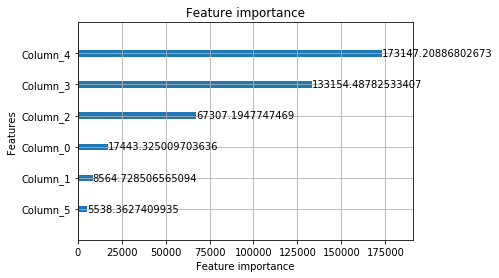

In [0]:
##LGBM でGrid Serch した場合の、Feature Importance
from lightgbm import LGBMClassifier, plot_importance
plot_importance(model_gs.best_estimator_, importance_type="gain")

In [0]:
# ひとまずローカルバリデーション。あまり結果はよくない。
# y_pred = model.predict(eval_X)
# accuracy = accuracy_score(y_pred, eval_y)
# print('Accuracy: {:3f}'.format(accuracy))

Accuracy: 0.632458


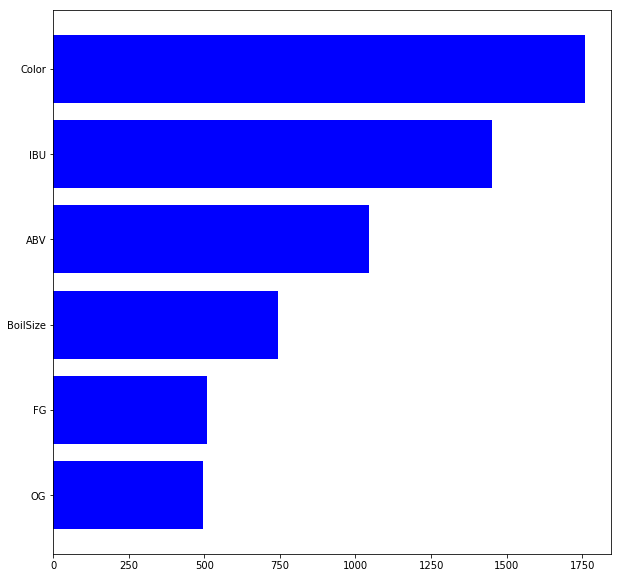

In [0]:
# feature importance
features = train_df.loc[:,USE_FEATURES].columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [0]:
##Data可視化//sns は宿題です
sns.lineplot(x="", y="", kind="line", data=df)

feature importancesを確認したところIBU（苦味の指標）, Colorの重要度が大きくついでABV（アルコール度数みたいなもの）が大きい。   


In [0]:
# 結果表示用にラベルのcsvを取り込む
# class_df = pd.read_csv('../../data/class_ids.csv')
class_df = pd.read_csv(path + 'class_ids.csv')
class_df.head()
beer_dict = {}

for i in range(class_df.shape[0]):
    beer_dict[class_df.loc[i,'class_ids']] = class_df.loc[i,'Style']
beer_list = class_df.sort_values('class_ids').Style.unique()

In [0]:
beer_dict

{1: 'American IPA',
 2: 'American Pale Ale',
 3: 'Imperial IPA',
 4: 'Saison',
 5: 'Blonde Ale',
 6: 'American Brown Ale',
 7: 'American Amber Ale',
 8: 'American Stout',
 9: 'Irish Red Ale',
 10: 'American Light Lager'}

In [0]:
# LIMEで予測結果を確認
explainer = lime.lime_tabular.LimeTabularExplainer(train_X, feature_names=USE_FEATURES, class_names=beer_list)


In [0]:
i = np.random.randint(0, eval_y.shape[0])
pred_beer = beer_dict[eval_y[i]]

print('True Value: {}'.format(pred_beer))

exp = explainer.explain_instance(eval_X[i], model.predict_proba, num_features=len(train_df.iloc[:,1:].columns), top_labels=1)
exp.show_in_notebook(show_table=True, show_all=True)


True Value: American IPA


## エラー分析
まずどのクラスにおいてエラーが多かったのか確認する

In [0]:
result_df = pd.DataFrame(y_pred, columns=['prediction'])
df_eval_result = pd.concat([df_eval.reset_index(drop=True), result_df], axis=1)
df_eval_result.head(20)


,class,OG,FG,ABV,IBU,Color,BoilSize,prediction
0,5,1.042,1.007,4.62,17.13,3.18,28.40,5
1,10,1.062,1.015,6.06,59.87,7.79,47.32,1
2,1,1.071,1.018,7.01,0.00,7.61,51.10,1
3,2,1.046,1.008,5.00,57.30,14.12,30.00,1
4,1,1.071,1.016,7.24,69.98,9.05,11.36,1
5,4,1.048,1.008,5.21,43.08,5.40,28.39,2
6,1,1.058,1.011,6.17,65.33,4.86,53.00,1
7,5,1.046,1.011,4.55,21.62,4.83,11.36,5
8,1,1.068,1.015,6.96,241.04,7.03,28.39,1
9,3,1.079,1.014,8.46,109.45,8.99,30.00,3


In [0]:
#正答率データの作成
result_true = df_eval_result[df_eval_result['class']==df_eval_result['prediction']]
result_false = df_eval_result[df_eval_result['class']!=df_eval_result['prediction']]

result_true.loc[:,'class'] = result_true.loc[:,'class'].map(beer_dict)
result_false.loc[:,'class'] = result_false.loc[:,'class'].map(beer_dict)


In [0]:
result_true.sort_values('class').loc[:,'class'].value_counts()

American IPA            1483
American Pale Ale        769
American Stout           184
Saison                   181
Blonde Ale               166
Imperial IPA             150
American Amber Ale       144
American Brown Ale       110
Irish Red Ale             96
American Light Lager      88
Name: class, dtype: int64

In [0]:
result_false.sort_values('class').loc[:,'class'].value_counts()

American Pale Ale       508
American IPA            450
American Light Lager    278
Saison                  246
American Amber Ale      200
Blonde Ale              141
Imperial IPA            135
Irish Red Ale            89
American Brown Ale       73
American Stout           37
Name: class, dtype: int64

In [0]:
true_cnt = result_true.sort_values('class').loc[:,'class'].value_counts()
false_cnt = result_false.sort_values('class').loc[:,'class'].value_counts()

result_df_new = pd.concat([true_cnt, false_cnt],axis=1)
result_df_new.columns = ['true', 'false']


In [0]:
result_df_new.loc[:,'ratio'] = result_df_new.apply(lambda x: x.loc['true'] / (x.loc['true']+x.loc['false']), axis=1)
result_df_new.head(10)


,true,false,ratio
American Amber Ale,144,185,0.437690
American Brown Ale,110,75,0.594595
American IPA,1483,421,0.778887
American Light Lager,88,272,0.244444
American Pale Ale,769,461,0.625203
American Stout,184,24,0.884615
Blonde Ale,166,106,0.610294
Imperial IPA,150,102,0.595238
Irish Red Ale,96,78,0.551724
Saison,181,235,0.435096


[Text(0, 0, 'American Amber Ale'),
 Text(0, 0, 'American Brown Ale'),
 Text(0, 0, 'American IPA'),
 Text(0, 0, 'American Light Lager'),
 Text(0, 0, 'American Pale Ale'),
 Text(0, 0, 'American Stout'),
 Text(0, 0, 'Blonde Ale'),
 Text(0, 0, 'Imperial IPA'),
 Text(0, 0, 'Irish Red Ale'),
 Text(0, 0, 'Saison')]

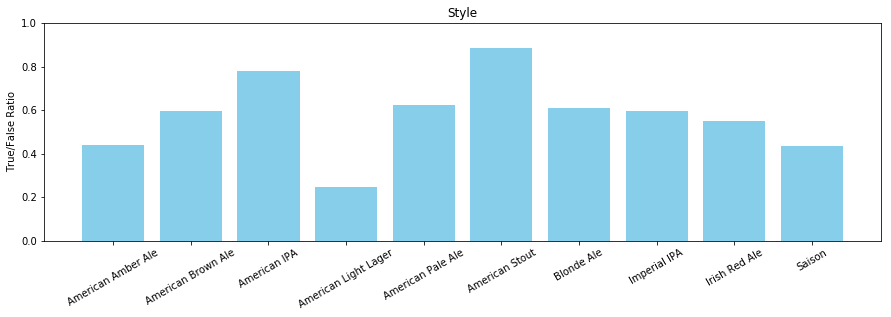

In [0]:
fig, ax = plt.subplots()
fig.set_figwidth(15)

true_false_ratio = np.array(result_df_new.loc[:,'ratio'])
ax.bar(np.arange(0,10),true_false_ratio, color='SkyBlue')

ax.set_ylim(0,1.0)
ax.set_ylabel('True/False Ratio')
ax.set_title('Style')
ax.set_xticks(np.arange(0,10))
ax.set_xticklabels(result_df_new.index,rotation=30)
